In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 15
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

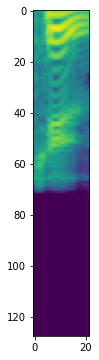

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.9576038877747042
TEST
loss: 0.45589621246501966
accuracy: 0.896774193548387
******************
epoch: 1
Train
0.33739313382131797
TEST
loss: 0.49623920622692314
accuracy: 0.8580645161290322
******************
epoch: 2
Train
0.2921860002996335
TEST
loss: 0.583793386977206
accuracy: 0.853763440860215
******************
epoch: 3
Train
0.21050383563829997
TEST
loss: 0.48184798975144666
accuracy: 0.8709677419354839
******************
epoch: 4
Train
0.19476137491214898
TEST
loss: 0.330864917911509
accuracy: 0.896774193548387
******************
epoch: 5
Train
0.18085119668263933
TEST
loss: 0.18928265513912323
accuracy: 0.9333333333333333
******************
epoch: 6
Train
0.12539970720719443
TEST
loss: 0.2185573306215066
accuracy: 0.9483870967741935
******************
epoch: 7
Train
0.16334510767530483
TEST
loss: 0.5246454746492447
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.10231772686244983
TEST
loss: 0.2092232463821288
accuracy: 0.9268817204301075
*****

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


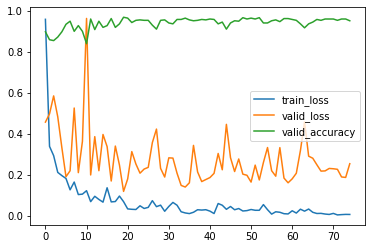

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0592615048475784
TEST
loss: 1.5185359442105857
accuracy: 0.6580645161290323
******************
epoch: 1
Train
0.39776980356946706
TEST
loss: 0.4123416466097678
accuracy: 0.853763440860215
******************
epoch: 2
Train
0.26650881902081514
TEST
loss: 0.2783982320498395
accuracy: 0.9118279569892473
******************
epoch: 3
Train
0.2465087945061983
TEST
loss: 0.5544299471762872
accuracy: 0.8193548387096774
******************
epoch: 4
Train
0.1974081263852877
TEST
loss: 0.3141505682981142
accuracy: 0.9161290322580645
******************
epoch: 5
Train
0.18706834239220196
TEST
loss: 0.4630108732049183
accuracy: 0.864516129032258
******************
epoch: 6
Train
0.14394666739991743
TEST
loss: 0.2034136261350365
accuracy: 0.9354838709677419
******************
epoch: 7
Train
0.14372433275867036
TEST
loss: 0.7352616537001825
accuracy: 0.8602150537634409
******************
epoch: 8
Train
0.14714639479425817
TEST
loss: 1.1394720633824666
accura

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


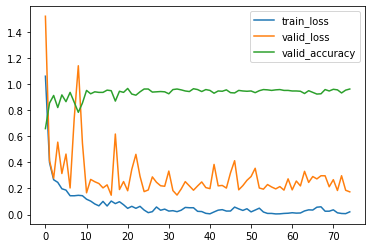

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0945269074180657
TEST
loss: 0.72932350789347
accuracy: 0.7655913978494624
******************
epoch: 1
Train
0.4146512036177184
TEST
loss: 0.2905933936116516
accuracy: 0.9053763440860215
******************
epoch: 2
Train
0.34121978835001643
TEST
loss: 0.6057006966683173
accuracy: 0.832258064516129
******************
epoch: 3
Train
0.31053501903593506
TEST
loss: 0.6755757808685303
accuracy: 0.8344086021505376
******************
epoch: 4
Train
0.24019282642204273
TEST
loss: 0.31028937671774176
accuracy: 0.896774193548387
******************
epoch: 5
Train
0.15696999836686998
TEST
loss: 0.19015556208549006
accuracy: 0.9376344086021505
******************
epoch: 6
Train
0.15012910093071002
TEST
loss: 0.3296006864117038
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.19946505192729436
TEST
loss: 0.29562576150381437
accuracy: 0.9096774193548387
******************
epoch: 8
Train
0.14586371377583915
TEST
loss: 0.356987299073127
accur

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


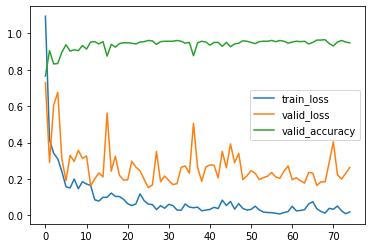

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0421714635067365
TEST
loss: 0.4857472090310948
accuracy: 0.8516129032258064
******************
epoch: 1
Train
0.3499237688626406
TEST
loss: 0.4762490668604451
accuracy: 0.8731182795698925
******************
epoch: 2
Train
0.25093329029822775
TEST
loss: 0.34019046989820334
accuracy: 0.8989247311827957
******************
epoch: 3
Train
0.23269439225050476
TEST
loss: 0.5742654267177787
accuracy: 0.843010752688172
******************
epoch: 4
Train
0.17425053294268614
TEST
loss: 0.8920789367409163
accuracy: 0.8
******************
epoch: 5
Train
0.20195490803908583
TEST
loss: 0.38880779275330163
accuracy: 0.9010752688172043
******************
epoch: 6
Train
0.16903838080363565
TEST
loss: 0.28224828608574404
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.10291086713039689
TEST
loss: 0.16618213666382656
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.08520310556272312
TEST
loss: 0.19633177429117182
accuracy: 0.94

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


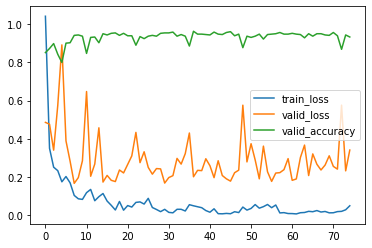

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9468024594846693
TEST
loss: 0.7719149811293489
accuracy: 0.7956989247311828
******************
epoch: 1
Train
0.36983001174372115
TEST
loss: 0.3162871869020565
accuracy: 0.9075268817204301
******************
epoch: 2
Train
0.2676925333713291
TEST
loss: 0.410165984143493
accuracy: 0.8881720430107527
******************
epoch: 3
Train
0.2015005478502026
TEST
loss: 0.32122906023456205
accuracy: 0.9053763440860215
******************
epoch: 4
Train
0.16479401718915376
TEST
loss: 0.6090276874521727
accuracy: 0.8473118279569892
******************
epoch: 5
Train
0.19192922051933803
TEST
loss: 0.1611092445831145
accuracy: 0.9548387096774194
******************
epoch: 6
Train
0.13587844690361137
TEST
loss: 0.3408361247790757
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.15496692855029448
TEST
loss: 0.2844353365641768
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.07892699067831424
TEST
loss: 0.35830927702688403
acc

In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


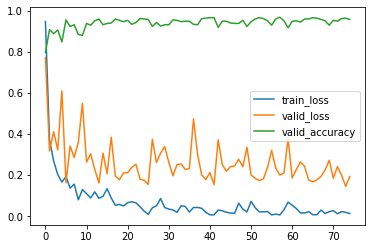

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0360996450990134
TEST
loss: 0.7061673520713724
accuracy: 0.8258064516129032
******************
epoch: 1
Train
0.42775078800717026
TEST
loss: 0.4294449506267424
accuracy: 0.8924731182795699
******************
epoch: 2
Train
0.37009371007458136
TEST
loss: 0.8393887847982427
accuracy: 0.7741935483870968
******************
epoch: 3
Train
0.31070426573468335
TEST
loss: 0.42835126608930607
accuracy: 0.8903225806451613
******************
epoch: 4
Train
0.24164685605351618
TEST
loss: 0.20087619782775962
accuracy: 0.9419354838709677
******************
epoch: 5
Train
0.20226635197734216
TEST
loss: 0.17954882050073276
accuracy: 0.9483870967741935
******************
epoch: 6
Train
0.20384564878610623
TEST
loss: 0.4052192036503105
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.1620336418462878
TEST
loss: 0.23154888617736036
accuracy: 0.9204301075268817
******************
epoch: 8
Train
0.12282706372636457
TEST
loss: 0.1718467468536028

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


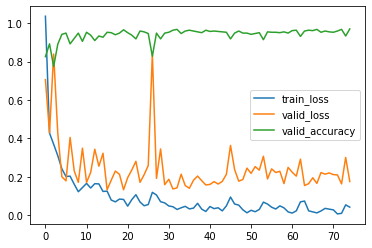

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.8711536830641213
TEST
loss: 4.004541767284434
accuracy: 0.3935483870967742
******************
epoch: 1
Train
1.356810277549567
TEST
loss: 1.0423638956521146
accuracy: 0.7505376344086021
******************
epoch: 2
Train
1.2561341646735746
TEST
loss: 0.5324068638586229
accuracy: 0.8021505376344086
******************
epoch: 3
Train
1.1548209670543927
TEST
loss: 0.46102957084614743
accuracy: 0.8623655913978494
******************
epoch: 4
Train
1.0734034860782489
TEST
loss: 0.5059360842550954
accuracy: 0.8451612903225807
******************
epoch: 5
Train
1.0375512134149374
TEST
loss: 0.44514746922318654
accuracy: 0.8580645161290322
******************
epoch: 6
Train
0.9909773345396733
TEST
loss: 0.3882627393609734
accuracy: 0.8881720430107527
******************
epoch: 7
Train
0.9833211195231383
TEST
loss: 0.4503606541823315
accuracy: 0.8580645161290322
******************
epoch: 8
Train
0.98537436312222
TEST
loss: 0.43773022941363754
accuracy: 0

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9449225473321858


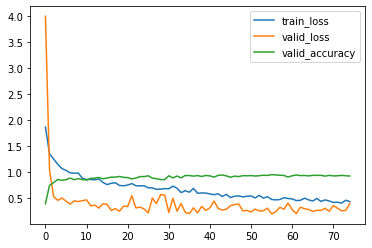

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.444384666559962
TEST
loss: 2.693098166681105
accuracy: 0.2860215053763441
******************
epoch: 1
Train
0.6929806956823756
TEST
loss: 1.3820203647818616
accuracy: 0.6258064516129033
******************
epoch: 2
Train
0.5561744092161706
TEST
loss: 0.8320867996062001
accuracy: 0.7247311827956989
******************
epoch: 3
Train
0.4239668425014087
TEST
loss: 0.6485725587414157
accuracy: 0.789247311827957
******************
epoch: 4
Train
0.33782179803699336
TEST
loss: 1.1672796492935509
accuracy: 0.6989247311827957
******************
epoch: 5
Train
0.3294168630144451
TEST
loss: 0.3926377176597554
accuracy: 0.8838709677419355
******************
epoch: 6
Train
0.2980019910141673
TEST
loss: 0.3293397363796029
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.1941480271329659
TEST
loss: 0.4360625700924986
accuracy: 0.864516129032258
******************
epoch: 8
Train
0.21233067913086234
TEST
loss: 0.35742638412342276
accuracy: 0

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9345955249569707


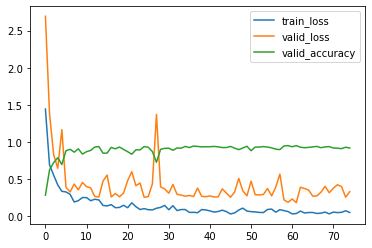

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0064623185107962
TEST
loss: 0.7637441985068782
accuracy: 0.7462365591397849
******************
epoch: 1
Train
0.37121057073853
TEST
loss: 0.36490487860095117
accuracy: 0.8881720430107527
******************
epoch: 2
Train
0.2398565350903833
TEST
loss: 0.2793397431091596
accuracy: 0.9139784946236559
******************
epoch: 3
Train
0.23393007905879967
TEST
loss: 0.48620843131055114
accuracy: 0.8559139784946237
******************
epoch: 4
Train
0.20383932302251065
TEST
loss: 0.3154185483532567
accuracy: 0.9204301075268817
******************
epoch: 5
Train
0.15712514373648853
TEST
loss: 0.28354124939569864
accuracy: 0.9333333333333333
******************
epoch: 6
Train
0.12193835192491884
TEST
loss: 0.44940485774829825
accuracy: 0.864516129032258
******************
epoch: 7
Train
0.15117621476379337
TEST
loss: 0.3045999211649741
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.1203051876792294
TEST
loss: 0.6771095355351766
accu

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9621342512908778


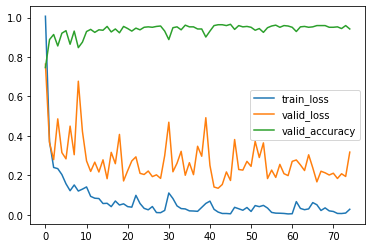

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9770983363199311
TEST
loss: 1.1147242187171853
accuracy: 0.7075268817204301
******************
epoch: 1
Train
0.3719649766810042
TEST
loss: 0.560548169894885
accuracy: 0.832258064516129
******************
epoch: 2
Train
0.2645297073586114
TEST
loss: 0.4511780498168802
accuracy: 0.864516129032258
******************
epoch: 3
Train
0.22728958210767952
TEST
loss: 0.7062504583789456
accuracy: 0.810752688172043
******************
epoch: 4
Train
0.18374786206195606
TEST
loss: 0.23150222383199198
accuracy: 0.9397849462365592
******************
epoch: 5
Train
0.17781899696919118
TEST
loss: 0.49720649123191835
accuracy: 0.853763440860215
******************
epoch: 6
Train
0.1549945611769497
TEST
loss: 0.3057766611217171
accuracy: 0.9032258064516129
******************
epoch: 7
Train
0.20367871198399964
TEST
loss: 0.2654225258737482
accuracy: 0.9247311827956989
******************
epoch: 8
Train
0.17807412202087344
TEST
loss: 0.20031490204154803
accurac

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


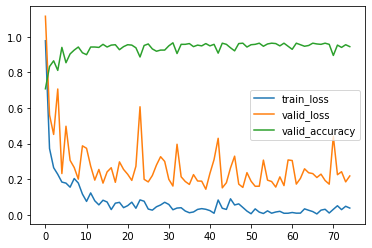

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0323012472161954
TEST
loss: 0.93221624307735
accuracy: 0.7376344086021506
******************
epoch: 1
Train
0.4360450495297253
TEST
loss: 0.43234629092677945
accuracy: 0.8602150537634409
******************
epoch: 2
Train
0.32091614528567675
TEST
loss: 0.5843446790531117
accuracy: 0.7720430107526882
******************
epoch: 3
Train
0.28978822452121994
TEST
loss: 0.44509033708162205
accuracy: 0.864516129032258
******************
epoch: 4
Train
0.21482395008808192
TEST
loss: 0.22650076266257993
accuracy: 0.9333333333333333
******************
epoch: 5
Train
0.21562482743219594
TEST
loss: 0.2706141382776281
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.19664588023336202
TEST
loss: 0.22330308985966507
accuracy: 0.9354838709677419
******************
epoch: 7
Train
0.14545508345722447
TEST
loss: 0.2395507231835396
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.155518445224934
TEST
loss: 0.22223276265205877
acc

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


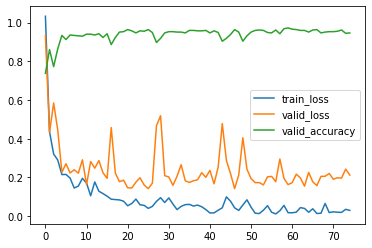

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.8374366707614371
TEST
loss: 1.618751089034542
accuracy: 0.6709677419354839
******************
epoch: 1
Train
1.3539931935909684
TEST
loss: 1.847807034113074
accuracy: 0.6193548387096774
******************
epoch: 2
Train
1.2337908283895103
TEST
loss: 1.1626699580941149
accuracy: 0.7118279569892473
******************
epoch: 3
Train
1.1217274963695256
TEST
loss: 0.352951471267208
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.9853428364056827
TEST
loss: 0.8616410388741442
accuracy: 0.7741935483870968
******************
epoch: 5
Train
1.0465775656969751
TEST
loss: 0.8642914313142017
accuracy: 0.7397849462365591
******************
epoch: 6
Train
0.9893648823423288
TEST
loss: 0.4246482285120154
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.9355116341148709
TEST
loss: 0.5482501675364791
accuracy: 0.8666666666666667
******************
epoch: 8
Train
0.8730176169190538
TEST
loss: 0.42236257330063853
accuracy: 0.8

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9242685025817556


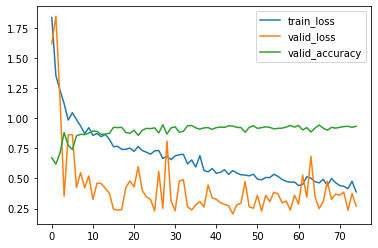

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0593656923543655
TEST
loss: 0.7833873897470454
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.4224984782577909
TEST
loss: 0.47295831813607164
accuracy: 0.8494623655913979
******************
epoch: 2
Train
0.3199480171799339
TEST
loss: 0.5340719828041651
accuracy: 0.8408602150537634
******************
epoch: 3
Train
0.26146707550196735
TEST
loss: 0.7953710793167033
accuracy: 0.7720430107526882
******************
epoch: 4
Train
0.24865611259437853
TEST
loss: 0.2923892694775776
accuracy: 0.9247311827956989
******************
epoch: 5
Train
0.18573816963178083
TEST
loss: 0.35783128392311836
accuracy: 0.9032258064516129
******************
epoch: 6
Train
0.17302309218182252
TEST
loss: 0.2217459802025108
accuracy: 0.9290322580645162
******************
epoch: 7
Train
0.16320469450681005
TEST
loss: 0.18653551445853325
accuracy: 0.9397849462365592
******************
epoch: 8
Train
0.1509076644880642
TEST
loss: 0.2287924123707638
ac

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9414802065404475


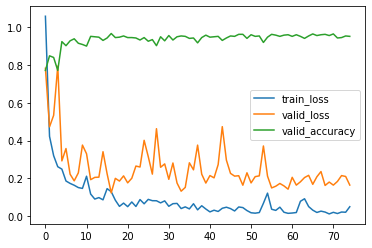

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.9638149056565588
TEST
loss: 1.9292649781832132
accuracy: 0.5655913978494623
******************
epoch: 1
Train
1.4838088103758114
TEST
loss: 1.344910749568734
accuracy: 0.6172043010752688
******************
epoch: 2
Train
1.3078209912192778
TEST
loss: 0.9467802173347883
accuracy: 0.7354838709677419
******************
epoch: 3
Train
1.1729746650609523
TEST
loss: 0.6065371486448472
accuracy: 0.810752688172043
******************
epoch: 4
Train
1.0800687278157997
TEST
loss: 0.5589391641719367
accuracy: 0.8473118279569892
******************
epoch: 5
Train
1.0270755328217949
TEST
loss: 0.7778327029238465
accuracy: 0.7677419354838709
******************
epoch: 6
Train
1.014618942412755
TEST
loss: 0.46458909838430346
accuracy: 0.8623655913978494
******************
epoch: 7
Train
0.9246807717224187
TEST
loss: 0.27924317083051126
accuracy: 0.9053763440860215
******************
epoch: 8
Train
0.9438530099475391
TEST
loss: 0.6500246190255689
accuracy: 0

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


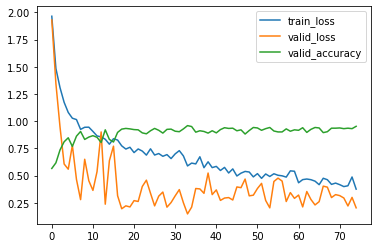

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.048827443767377
TEST
loss: 0.8440935325878922
accuracy: 0.7591397849462366
******************
epoch: 1
Train
0.3746362149747521
TEST
loss: 0.46420836012850525
accuracy: 0.8623655913978494
******************
epoch: 2
Train
0.27089561960937264
TEST
loss: 0.41537603960242325
accuracy: 0.8817204301075269
******************
epoch: 3
Train
0.21766567592923847
TEST
loss: 0.6012101868147491
accuracy: 0.8365591397849462
******************
epoch: 4
Train
0.20364695925448104
TEST
loss: 0.2916636847680615
accuracy: 0.9053763440860215
******************
epoch: 5
Train
0.15092445620299028
TEST
loss: 0.43366830874514833
accuracy: 0.8795698924731182
******************
epoch: 6
Train
0.16192250994501026
TEST
loss: 0.2418849250001292
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.14549114984020342
TEST
loss: 0.18495902444726678
accuracy: 0.9440860215053763
******************
epoch: 8
Train
0.07626487153412259
TEST
loss: 0.3275144325789585


In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9690189328743546


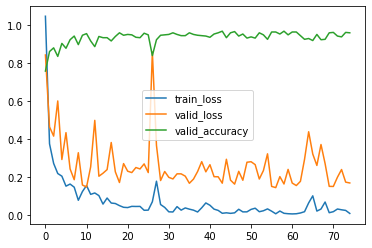

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0426092699900327
TEST
loss: 0.7206099334583488
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.4314022584184884
TEST
loss: 0.7260076799700337
accuracy: 0.7935483870967742
******************
epoch: 2
Train
0.35048308446963244
TEST
loss: 1.134574265890224
accuracy: 0.7053763440860215
******************
epoch: 3
Train
0.31949180663113447
TEST
loss: 1.8192502924191054
accuracy: 0.6924731182795699
******************
epoch: 4
Train
0.2901717702836585
TEST
loss: 0.2452065574866469
accuracy: 0.9354838709677419
******************
epoch: 5
Train
0.21244874848559395
TEST
loss: 0.2575945256858744
accuracy: 0.9225806451612903
******************
epoch: 6
Train
0.2945668363866462
TEST
loss: 0.28997446619054323
accuracy: 0.9096774193548387
******************
epoch: 7
Train
0.17454826926504596
TEST
loss: 0.37075731856848604
accuracy: 0.8903225806451613
******************
epoch: 8
Train
0.15278626377375842
TEST
loss: 0.5234551750203614
accu

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


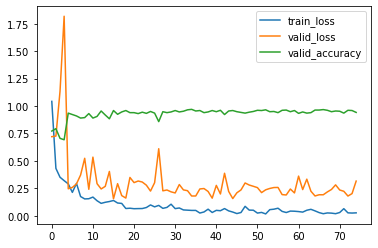

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9736954730623951
TEST
loss: 1.3178111414755544
accuracy: 0.7225806451612903
******************
epoch: 1
Train
0.40488486400392665
TEST
loss: 0.34547556863036205
accuracy: 0.9010752688172043
******************
epoch: 2
Train
0.2876583090634775
TEST
loss: 0.3517329216003418
accuracy: 0.8731182795698925
******************
epoch: 3
Train
0.178495209553772
TEST
loss: 0.9000506492712165
accuracy: 0.8
******************
epoch: 4
Train
0.25279799833949945
TEST
loss: 0.31924721271761003
accuracy: 0.9053763440860215
******************
epoch: 5
Train
0.16839758830729773
TEST
loss: 0.26170427183149964
accuracy: 0.9311827956989247
******************
epoch: 6
Train
0.16766114483999192
TEST
loss: 0.2344220547265904
accuracy: 0.9268817204301075
******************
epoch: 7
Train
0.12449966212980325
TEST
loss: 0.23825010827151677
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.1208349755921541
TEST
loss: 0.29904019271814697
accuracy: 0.9225

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9535283993115319


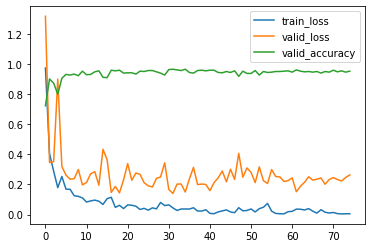

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0308641635029947
TEST
loss: 1.2391253266283262
accuracy: 0.6666666666666666
******************
epoch: 1
Train
0.4496539480659226
TEST
loss: 0.3598578778646326
accuracy: 0.8924731182795699
******************
epoch: 2
Train
0.37806149856596144
TEST
loss: 0.683243143045774
accuracy: 0.8
******************
epoch: 3
Train
0.2715237962987773
TEST
loss: 0.5746708882111375
accuracy: 0.8795698924731182
******************
epoch: 4
Train
0.26694153898431205
TEST
loss: 0.2312692669771051
accuracy: 0.9311827956989247
******************
epoch: 5
Train
0.19853421150996087
TEST
loss: 0.2872033680318504
accuracy: 0.9204301075268817
******************
epoch: 6
Train
0.15769667153918235
TEST
loss: 0.1654269230622117
accuracy: 0.9483870967741935
******************
epoch: 7
Train
0.16240302395069542
TEST
loss: 0.2038663092479911
accuracy: 0.9419354838709677
******************
epoch: 8
Train
0.1384342152446781
TEST
loss: 0.22855308244946182
accuracy: 0.93548387

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


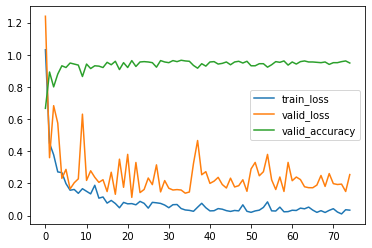

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9905446081567209
TEST
loss: 1.205991950342732
accuracy: 0.7139784946236559
******************
epoch: 1
Train
0.41470984171716896
TEST
loss: 0.377907020238138
accuracy: 0.875268817204301
******************
epoch: 2
Train
0.33936511943850006
TEST
loss: 0.6140327199812858
accuracy: 0.810752688172043
******************
epoch: 3
Train
0.21889295199896996
TEST
loss: 0.523368380338915
accuracy: 0.8666666666666667
******************
epoch: 4
Train
0.19743165394665416
TEST
loss: 0.3631425872925789
accuracy: 0.896774193548387
******************
epoch: 5
Train
0.17003235754927576
TEST
loss: 0.4628202412718086
accuracy: 0.8602150537634409
******************
epoch: 6
Train
0.16717239646226023
TEST
loss: 0.3229806463244141
accuracy: 0.896774193548387
******************
epoch: 7
Train
0.15927688237410048
TEST
loss: 0.2048297800684488
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.12470838800674494
TEST
loss: 0.7536905911660964
accuracy:

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


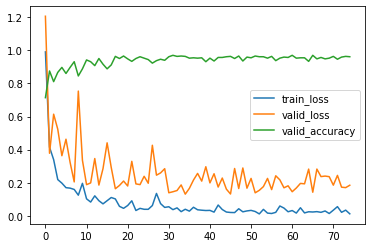

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.317907265584573
TEST
loss: 0.8332678853824574
accuracy: 0.7720430107526882
******************
epoch: 1
Train
0.5981376443296976
TEST
loss: 0.4711200132164904
accuracy: 0.864516129032258
******************
epoch: 2
Train
0.5039268276931524
TEST
loss: 0.5391406468165818
accuracy: 0.8301075268817204
******************
epoch: 3
Train
0.3586614646767825
TEST
loss: 0.35680989291398757
accuracy: 0.8989247311827957
******************
epoch: 4
Train
0.3292628440024972
TEST
loss: 0.35887585275916645
accuracy: 0.9010752688172043
******************
epoch: 5
Train
0.29121977299467877
TEST
loss: 0.7325969175625873
accuracy: 0.8193548387096774
******************
epoch: 6
Train
0.3582334674425387
TEST
loss: 0.4690683517404782
accuracy: 0.8731182795698925
******************
epoch: 7
Train
0.26397909598769076
TEST
loss: 0.18360311353719364
accuracy: 0.9548387096774194
******************
epoch: 8
Train
0.1875747612922758
TEST
loss: 0.2708331585891785
accurac

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


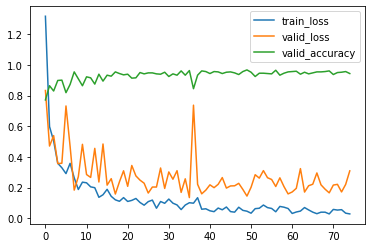

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()